In [1]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ['HUGGINGFACEHUB_API_TOKEN'] = user_secrets.get_secret("HUGGINGFACEHUB_API_TOKEN")
# os.environ['WANDB_API_KEY'] = user_secrets.get_secret("WANDB_API_KEY ")

from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACEHUB_API_TOKEN")
login(token = hf_token)

# REQUIREMENTS

In [2]:
%%writefile requirements.txt
datasets==3.2.0
accelerate==1.2.1
peft==0.14.0
trl==0.14.0
bitsandbytes==0.45.1
git+https://github.com/huggingface/transformers
wandb==0.19.1
omegaconf==2.3.0
pyyaml==6.0.2
hydra-core==1.3.2
python-dotenv==1.0.1
evaluate==0.4.3
rouge_score==0.1.2
py7zr==0.22.0
triton==3.2.0
vllm==0.7.3

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt -q


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# GENERATE PREDICTION

In [4]:
%%writefile generate.yaml

model:
    pretrained_model_name_or_path: google/paligemma-3b-mix-224
    pretrained_processor_name_or_path: google/paligemma-3b-mix-224
    load_in_4bit: false
    load_in_8bit: false
    bnb_4bit_compute_dtype: null
    bnb_4bit_quant_type: "nf4"
    bnb_4bit_use_double_quant: false
    bnb_4bit_quant_storage: "uint8"


input:
    image_path_or_url: 
    input_text: 

generate:
    use_vllm: False
    max_new_tokens: 1024
    temperature: null
    do_sample: null
    top_p: null
    # num_beams: 4,    
    # num_return_sequences: 4,
    # return_dict_in_generate: True,
    # output_scores: True,
    do_postprocess: false
    return_full: false

device:
  use_cpu: False


Overwriting generate.yaml


In [5]:
%%writefile generate.py
import importlib
import requests
import torch
from io import BytesIO
from PIL import Image
from omegaconf import OmegaConf
from transformers import AutoConfig, AutoModel, AutoProcessor, BitsAndBytesConfig
from vllm import LLM, SamplingParams


def get_model_class(pretrained_model_name_or_path):
    """
    Dynamically retrieves the model class from Hugging Face transformers 
    using the model's configuration.

    Args:
        pretrained_model_name_or_path (str): The name or local path of the model.

    Returns:
        model_class (transformers.PreTrainedModel): The corresponding model class.
    """
    # Load the model configuration
    config = AutoConfig.from_pretrained(pretrained_model_name_or_path)

    # Extract the model class name
    model_class_name = config.architectures[0] if config.architectures else None

    if model_class_name:
        try:
            # Dynamically import the model class
            module = importlib.import_module("transformers")
            return getattr(module, model_class_name, AutoModel)
        except (ImportError, AttributeError):
            pass  # Fallback if import fails

    return AutoModel  # Default to AutoModel if class is not found


def load_processor(model_args):  # For pre-processing input data (e.g., tokenizng text or resizing models) and post-processing model's outputs (e.g., decoding)
    processor = AutoProcessor.from_pretrained(model_args['pretrained_processor_name_or_path'])

    return processor
    

def set_torch_dtype_and_attn_implementation():
    # Set torch dtype and attention implementation
    try:
        if torch.cuda.get_device_capability()[0] >= 8:
            # !pip install -qqq flash-attn
            torch_dtype = torch.bfloat16
            attn_implementation = "flash_attention_2"
        else:
            torch_dtype = torch.float16
            attn_implementation = "eager"
    except:
        torch_dtype = torch.float16
        attn_implementation = "eager"

    return torch_dtype, attn_implementation

def get_quantization_config(model_args                          
) -> BitsAndBytesConfig | None:
    if model_args['load_in_4bit']:
        # compute_dtype = torch.float16
        # if torch_dtype not in {"auto", None}:
        #     compute_dtype = getattr(torch, model_args.torch_dtype)
        torch_dtype, attn_implementation = set_torch_dtype_and_attn_implementation()

        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            # bnb_4bit_compute_dtype=model_args['bnb_4bit_compute_dtype'],
            bnb_4bit_compute_dtype=torch_dtype,
            bnb_4bit_quant_type=model_args['bnb_4bit_quant_type'],
            bnb_4bit_use_double_quant=model_args['bnb_4bit_use_double_quant'],
            bnb_4bit_quant_storage=model_args['bnb_4bit_quant_storage'],
        ).to_dict()
    elif model_args['load_in_8bit']:
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
        ).to_dict()
    else:
        quantization_config = None

    return quantization_config

def load_model(model_args, device_args):

    # Set torch_dtype and attn_implementation
    torch_dtype, attn_implementation = set_torch_dtype_and_attn_implementation()

    # QLora Config
    quantization_config = get_quantization_config(model_args)

    model_class = get_model_class(model_args['pretrained_model_name_or_path'])

    # Load model
    model = model_class.from_pretrained(
        model_args['pretrained_model_name_or_path'],
        trust_remote_code=True,
        torch_dtype=torch_dtype,
        quantization_config=quantization_config if not device_args['use_cpu'] else None,
        device_map="cpu" if device_args['use_cpu'] else "auto",
        attn_implementation=attn_implementation,
        # low_cpu_mem_usage=True if not use_cpu else False
    )

    return model

def load_model_vllm(model_args, device_args):
    # Set torch_dtype and attn_implementation
    torch_dtype, attn_implementation = set_torch_dtype_and_attn_implementation()

    llm = LLM(
        model=model_args['pretrained_model_name_or_path'],
        dtype=torch_dtype
        )

    return llm

    
def load_image(image_path_or_url):
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)) #.convert('RGB')
    else:
        image = Image.open(image_path_or_url) #.convert('RGB')
    return image

def generate(model_args, input_args, gen_args, device_args):
    # Load the model and processor
    model = load_model(model_args, device_args)
    processor = load_processor(model_args)

    image = load_image(input_args['image_path_or_url'])
    
    # Preprocess the input
    inputs = processor(input_args['input_text'], image, return_tensors="pt")
    inputs = inputs.to(model.device)
    
    # Generate the output
    output = model.generate(**inputs, 
                            max_new_tokens=gen_args['max_new_tokens'],
                            do_sample=gen_args['do_sample'],
                            temperature=gen_args['temperature']
                           )
    # Decode and print the result
    response = processor.decode(output[0], skip_special_tokens=True) #[len(prompt):])

    return response


def generate_vllm(model_args, input_args, gen_args, device_args):
    # Load model
    llm = load_model_vllm(model_args, device_args)

    
    text = input_args['input_text']
    image = load_image(input_args['image_path_or_url'])

    outputs = llm.generate({
        "prompt": text,
        "multi_modal_data": {
        "image": image
        }
    } )

    responses = []
    for o in outputs:
        generated_text = o.outputs[0].text
        responses.append(generated_text)

    return responses


def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description="Load generation config.")
    
    parser.add_argument("--config_path", type=str, required=True, help="Path to the YAML config file for generating.")
    parser.add_argument("--image_path_or_url", type=str, default=None, help="Path or URL of the input image.")
    parser.add_argument("--input_text", type=str, default=None, help="The text input (question).")

    return parser.parse_args()


if __name__ == "__main__":
    args = parse_args()

    # Load the generation config file
    cfg = OmegaConf.load(args.config_path)

    # print(OmegaConf.to_yaml(cfg))

    model_args = cfg.model
    input_args = cfg.input
    gen_args = cfg.generate
    device_args = cfg.device

    if args.image_path_or_url and args.input_text:
        input_args.image_path_or_url = args.image_path_or_url
        input_args.input_text = args.input_text
    
    # Generate
    if gen_args.use_vllm:
        responses = generate_vllm(model_args, input_args, gen_args, device_args)
    else:
        responses = generate(model_args, input_args, gen_args, device_args)
    print('-'*96)
    print(responses)
    

Overwriting generate.py


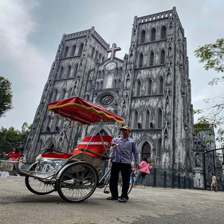

In [6]:
from IPython.display import display
from PIL import Image

# Load and display the image
image_path = "/kaggle/input/examples-hanoi-street/img1.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))
display(img)


In [7]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/examples-hanoi-street/img1.jpg' --input_text='Cho biết nội dung bức ảnh'

2025-02-23 09:53:33.554571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:53:33.575579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:53:33.582025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.21s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

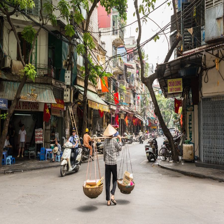

In [8]:
# Load and display the image
image_path = "/kaggle/input/examples-hanoi-street/img2.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))
display(img)


In [9]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/examples-hanoi-street/img2.jpg' --input_text='Cho biết nội dung bức ảnh'

2025-02-23 09:53:56.722512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:53:56.743434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:53:56.750436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.08s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

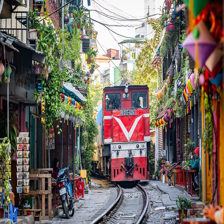

In [10]:
# Load and display the image
image_path = "/kaggle/input/examples-hanoi-street/img3.jpg"
img = Image.open(image_path)
img = img.resize((224, 224))
display(img)


In [11]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/examples-hanoi-street/img3.jpg' --input_text='Cho biết nội dung bức ảnh'

2025-02-23 09:54:19.672607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:54:19.693525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:54:19.700761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.08s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

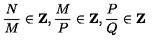

In [12]:
# Load and display the image
image_path = "/kaggle/input/example-unsloth-latex-ocr/img1.jpg"
img = Image.open(image_path)
# img = img.resize((224, 224))
display(img)


In [13]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/example-unsloth-latex-ocr/img1.jpg' --input_text='Cho biết nội dung bức ảnh'

2025-02-23 09:54:42.380942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:54:42.402540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:54:42.408801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.09s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

In [14]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/example-unsloth-latex-ocr/img1.jpg' --input_text='Cho biết biểu thức toán học trong ảnh'

2025-02-23 09:55:05.495397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:55:05.517212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:55:05.523587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.18s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

In [15]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/example-unsloth-latex-ocr/img1.jpg' --input_text='What is the mathematical expression in the image?'

2025-02-23 09:55:28.288712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:55:28.310189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:55:28.316881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.12s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

In [16]:
!python generate.py --config_path=generate.yaml --image_path_or_url='/kaggle/input/example-unsloth-latex-ocr/img1.jpg' --input_text='Chuyển biểu thức trong ảnh thành dạng latex'

2025-02-23 09:55:51.585402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 09:55:51.606737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 09:55:51.613260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:06<00:00,  2.12s/it]
You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transform

# DATA PREPARATION

In [ ]:
%%writefile vlm_sft_latex-ocr.yaml

exp_manager:
    prj_name: vlm_sft_latex-ocr
    exp_name: "vlm_sft_latex" #"sft_arcee-vylinh_gsm8k"
    seed: 202502
    task_name: 'vqa'
    dataset_name: unsloth-latex-ocr
    model_name:
    phase_name: evaluate
    wandb:
        use_wandb: true
        project: vlm_sft_latex
        log_artifact: false
        artifact_types: ['exp', 'data', 'configs', 'results', 'checkpoints']
    log:

prepare_data:
  dataset:
    is_prepared: false
    data_path: unsloth/LaTeX_OCR
    is_dataset_dict: true
    input_col: "problem"
    output_col: "solution"
    context_col: 
    do_split: true
    val_ratio: 0.25
    test_ratio: 0.2
    do_save: true
    prepared_data_path: ./exps/vlm_sft_latex/data/vlm_sft_latex.pkl
  prompt:
    use_model_chat_template: false
    instruction_key: '### Instruction:'
    instruction_text: "Bạn là chuyên gia toán học. Giải bài toán sau. Lời giải của bạn nên chứa 2 phần: Explanation và Answer. Phần Explanation trình bày cách thực hiện lời giải. Phần Answer chỉ chứa số như câu trả lời và không chứa bất kỳ kí tự nào khác."
    context_key: 
    input_key: '### Problem:'
    response_key: '### Solution:'
    end_key: null
  tokenizer:
    new_pad_token: null
    do_tokenize: true
    truncation: true
    padding: max_length
    add_special_tokens: false
    max_length: 512

prepare_model: 
    pretrained_model_name_or_path: "google/paligemma-3b-mix-224"
    pretrained_processor_name_or_path: "google/paligemma-3b-mix-224"
    load_in_4bit: true
    load_in_8bit: false
    bnb_4bit_compute_dtype: 
    bnb_4bit_quant_type: "nf4"
    bnb_4bit_use_double_quant: false
    bnb_4bit_quant_storage: "uint8"
    
train:
  use_peft: True
  lora:
    r: 64
    lora_alpha: 32
    lora_dropout: 0.0
    bias: none
    task_type: CAUSAL_LM
    inference_mode: false
    target_modules: ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    modules_to_save:
  do_merge: true
  train_n_samples: 100
  val_n_samples: 10
  test_n_samples: 10
  train_args:
    _target_: transformers.TrainingArguments
    resume_from_checkpoint: 
    do_train: false
    do_eval: true
    do_predict: false
    learning_rate: 0.0001
    num_train_epochs: 1
    # max_steps: 1
    per_device_train_batch_size: 2
    per_device_eval_batch_size: 2
    # logging_strategy: "no"
    logging_steps: 1
    logging_first_step: true
    save_strategy: epoch
    eval_strategy: steps
    eval_steps: 50
    eval_accumulation_steps: 1
    eval_on_start: true
    use_cpu: false
    report_to: None


generate:
  use_vllm: False
  max_new_tokens: 10
  pad_token_id: null
  skip_special_tokens: True
  do_sample:
  temperature: 

evaluate:
  batch_size: 8
  break_step: 1  # break evaluation if step >= break_step, -1 means no breaking
  prediction_file: 'test_predictions.txt'
  result_file: 'test_result.txt'

In [ ]:
%%writefile src/utils/model.utils.py

In [ ]:
%%writefile prepare_data.py
import os
import shutil
import joblib
import argparse
from functools import partial

from datasets import load_dataset

from src.utils.model_utils import load_tokenizer

import os
import argparse
import joblib

from dotenv import load_dotenv

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, set_seed
from src.utils.model_utils import load_tokenizer, load_model

from src.utils.log_utils import setup_logger
from src.utils.exp_utils import setup_environment, create_exp_dir

import pandas as pd
from datasets import Dataset, DatasetDict


import warnings
warnings.filterwarnings("ignore")

def load_cfg(config_path, override_args=None, print_cfg=True):

    """
    Load a configuration file using Hydra and OmegaConf.
    
    Args:
        config_path (str): Path to the configuration file.
        override_args (list, optional): List of arguments to override configuration values.

    Returns:
        cfg: Loaded configuration object.
    """

    override_args = override_args or []
    config_path = os.path.normpath(config_path)
    
    if not os.path.isfile(config_path):
        raise FileNotFoundError(f"Configuration file not found at: {config_path}")
    
    config_dir = os.path.dirname(config_path)
    config_fn = os.path.splitext(os.path.basename(config_path))[0]
    
    try:
        with initialize(version_base=None, config_path=config_dir):
            cfg = compose(config_name=config_fn, overrides=override_args)
    except Exception as e:
        raise RuntimeError(f"Failed to load configuration from {config_path}: {e}")
    
    # assert os.path.basename(config_path).replace('.yaml', '') == cfg.exp_manager.exp_name, \
    # assert cfg.exp_manager.phase_name + '__' + 
    assert cfg.exp_manager.exp_name == os.path.basename(config_path).replace('.yaml', ''), \
    f"Config file name '{os.path.basename(config_path)}' does not match experiment name '{cfg.exp_manager.exp_name}' in the config."

    if print_cfg:
        print(OmegaConf.to_yaml(cfg))
    
    exp_args = cfg.exp_manager
    data_args = cfg.prepare_data
    model_args = cfg.prepare_model
    train_args = cfg.train
    eval_args = cfg.eval
    gen_args = cfg.generate

    return cfg, exp_args, data_args, model_args, train_args, eval_args, gen_args

def create_dataset_dict(data_path, 
                        do_split: bool=True, 
                        val_ratio: float=0.25,
                        test_ratio: float=0.2,
                        seed: int = 42):
    df = pd.read_csv(data_path)
    hf_dataset = Dataset.from_pandas(df)

  
    if do_split:
        # Splitting the dataset
        train_test_split = hf_dataset.train_test_split(test_size=test_ratio, seed=seed)
        train_val_split = train_test_split["train"].train_test_split(test_size=val_ratio, seed=seed)  # 0.25 x 0.8 = 0.2
    
        # Create DatasetDict
        dataset_dict = DatasetDict({
            "train": train_val_split["train"],
            "val": train_val_split["test"],
            "test": train_test_split["test"]
        })
        
    else:
        dataset_dict = DatasetDict({
            "train": hf_dataset
        })
    return dataset_dict


def show_dataset_examples(dataset_dict):
    """
    Prints the length, columns, shape of columns, and an example from each split of a DatasetDict (train, val, test).

    Parameters
    ----------
    dataset_dict : datasets.DatasetDict
        A DatasetDict containing train, val, and test splits.

    Returns
    -------
    None
    """
    for split_name, dataset in dataset_dict.items():
        # Get the length and columns of the current split
        dataset_length = len(dataset)
        dataset_columns = dataset.column_names

        print(f"\nSplit: {split_name}")
        print(f"Number of Examples: {dataset_length}")
        print(f"Columns: {dataset_columns}")

        # Calculate the shape of each column
        print("Shapes:")
        for column_name in dataset_columns:
            if column_name in dataset[0]:
                col_data = dataset[column_name]
                if isinstance(col_data[0], list):  # Multi-dimensional data (e.g., tokenized inputs)
                    print(f"  {column_name}: [{len(col_data)}, {len(col_data[0])}]")
                else:  # Single-dimensional data (e.g., strings)
                    print(f"  {column_name}: [{len(col_data)}]")

        # Get the first example from the current split
        example = dataset[0]

        print("An example:")
        for key, value in example.items():
            print(f"  {key}: {value}")

    print("-" * 24 + "\n")


def has_system_role_support(tokenizer):
    messages = [
            {
                "role": "system",
                "content": "You are a helpful assistant."
            },
            {
                "role": "user",
                "content": "Who won the FIFA World Cup 2022?"
            },
            {
                "role": "assistant",
                "content": "Argentina won the FIFA World Cup 2022, defeating France in the final."
            }
    ]

    try: 
        tokenizer.apply_chat_template(messages, tokenize=False)
        return True
    except:
        return False



def create_prompt_formats(example,
                          tokenizer,
                          use_model_chat_template,
                          input_col: str="question",
                          output_col: str="answer",
                          context_col: str="context",

                          use_no_keys: str=False,
                          use_examples: str=False,
                          use_context: str=False,
                          
                          intro_text: str="You are a knowledgeable assistant for the company CMC Global.",
                          instruction_key: str="### Instruction:",
                          instruction_text: str="Your task is to providing accurate and helpful answers to the user's questions about the company.",

                          examples_key: str="### Examples:",
                          examples_template: str="",
                          examples_list: list=[],
                          
                          context_key: str="### Context:",
                          input_key: str = "### Question:",
                          response_key: str = "### Answer:",
                          end_key = None,
                          
                          do_tokenize = False, 
                          max_length = None, 
                          phase_name='eval'
):
    if use_no_keys:
        return f'{example[input_col]}'
    
    intro = f'{intro_text}'
    instruction = f'{instruction_key}\n{instruction_text}'

    examples = None
    if use_examples:
        example_template = examples_template
        formatted_examples = "\n".join(
            example_template.format(**example) for example in examples_list
        )
        examples = f"{examples_key}\n{formatted_examples}".strip()
    
    context = f'{context_key}\n{example[context_col]}' if (use_context and context_col) else None

    input = f'{input_key}\n{example[input_col]}'

    if phase_name == 'train':
        response = f'{response_key}\n{example[output_col]}'
    
    elif phase_name == 'eval':
        response = f'{response_key}\n'
    
    if not end_key:
        end_key = tokenizer.eos_token
    
    end = f'{end_key}'
    
    if not use_model_chat_template:  # Not using default model chat template
        parts = [part for part in [intro, instruction, examples, context, input, response] if part]
        formatted_prompt = "\n\n".join(parts)
    
    else:   # Using defaut model chat template
        if has_system_role_support(tokenizer):

            if context_col:
                input = f'{context}\n{input}'
            messages = [
                {"role": "system", "content": instruction},
                {"role": "user", "content": input},
                {"role": "assistant", "content": response},   
            ]
            formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

        else:
            if context_col:
                input = f'{context}\n{input}'
            messages = [
                {"role": "user", "content": instruction + '\n' + input},
                {"role": "assistant", "content": response},
            ]
            formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

    
    if phase_name == 'train':
        if formatted_prompt.strip().endswith(end):
            example['text'] = formatted_prompt
            # print('endswith end')
        else:
            # print('does not ends with end')
            example['text'] = formatted_prompt + end
    
    elif phase_name == 'eval':
        example['text'] = formatted_prompt

    if do_tokenize:
        tokenized_text = tokenizer(formatted_prompt, 
                                   truncation=True, 
                                   padding='max_length', 
                                   add_special_tokens=True, 
                                   max_length=max_length,
                                   return_tensors='pt'
                                   )

        
        example['input_ids'] = tokenized_text['input_ids']
        example['attention_mask'] = tokenized_text['attention_mask']

    return example
        
    
def save_dataset(dataset, save_path):
    joblib.dump(dataset, save_path)
    
def get_data_collator():
    pass

def prepare_data(exp_args, data_args, model_args):

    if data_args.dataset.is_dataset_dict:
        dataset_dict = load_dataset(data_args.dataset.data_path,
                                    trust_remote_code=True)
    
    else:    
        dataset_dict = create_dataset_dict(data_args.dataset.data_path, 
                                           data_args.dataset.do_split, 
                                           data_args.dataset.val_ratio, 
                                           data_args.dataset.test_ratio, 
                                           exp_args.seed)
        

    if data_args.dataset.subset_ratio and 0 < data_args.dataset.subset_ratio < 1:
        
        dataset_dict = DatasetDict({
            split: dataset_dict[split].shuffle(seed=exp_args.seed).select(range(int(len(dataset_dict[split]) * data_args.dataset.subset_ratio)))
            for split in dataset_dict.keys()
        }) 
    
    tokenizer = load_tokenizer(data_args, model_args)

    _create_prompt_formats = partial(
        create_prompt_formats,
          tokenizer = tokenizer,
          use_model_chat_template = data_args.prompt.use_model_chat_template,
          input_col = data_args.dataset.input_col,
          output_col = data_args.dataset.output_col,
          context_col = data_args.dataset.context_col,

          use_no_keys = data_args.prompt.use_no_keys,
          use_examples = data_args.prompt.use_examples,
          use_context = data_args.prompt.use_context,
                          
          
          intro_text = data_args.prompt.intro_text, 
          instruction_key = data_args.prompt.instruction_key, # "### Instruction:",
          instruction_text = data_args.prompt.instruction_text, # "You are a knowledgeable assistant for the company CMC Global. Your task is to providing accurate and helpful answers to the user's questions about the company.",
          
          examples_key = data_args.prompt.examples_key,
          examples_template = data_args.prompt.examples_template,
          examples_list = data_args.prompt.examples_list,

          context_key =  data_args.prompt.context_key,
          input_key = data_args.prompt.input_key, #"### Question:",
          response_key = data_args.prompt.response_key, #"### Answer:",
          end_key = data_args.prompt.end_key,

          do_tokenize = data_args.tokenizer.do_tokenize, 
          max_length = data_args.tokenizer.max_length,
          phase_name = exp_args.phase_name
    )

    columns_to_remove = [col for col in dataset_dict['train'].column_names if col not in ['index', 'answer', 'text']]

    dataset = dataset_dict.map(
        _create_prompt_formats, 
         batched=False, 
         remove_columns=columns_to_remove
    )

    if data_args.dataset.do_save:
        save_path = data_args.dataset.prepared_data_path
        save_dataset(dataset, save_path)

    return dataset, save_path


def main():

   # Setup logging
    logger = setup_logger()

    # Setup environment
    logger.info("SETTING UP ENVIRONMENT...")
    setup_environment()

    # Parse arguments
    parser = argparse.ArgumentParser(description='Load experiment configurations.')
    parser.add_argument(
        '--config_path',
        type=str,
        required=True,
        help='Path to the configuration file for the experiment.'
    )

    args, override_args = parser.parse_known_args()

    # Load configuration
    logger.info("LOADING CONFIGURATIONS...")
    cfg, exp_args, data_args, model_args, train_args, eval_args, gen_args = load_cfg(config_path=args.config_path, override_args=override_args)
    
    # Create experiment directories
    # logger.info("CREATING DIRECTORIES...")""
    exp_name = cfg.exp_manager.exp_name
    (exp_dir, exp_data_dir, exp_checkpoints_dir, exp_results_dir) = create_exp_dir(exp_name)

    import shutil
    shutil.copy(args.config_path, exp_dir)

    # # Set seed
    # set_seed(exp_args.seed)

    # if data_args.dataset.is_prepared:
    #     # Get the path to the processed data
    #     processed_data_path = os.path.normpath(data_args.dataset.prepared_data_path)
        
    #     # Check if the processed data exists
    #     if not os.path.isfile(processed_data_path):
    #         raise FileNotFoundError(f"Processed data not found at: {processed_data_path}")
        
    #     # Load the dataset
    #     logger.info("LOADING PROCESSED DATASET...")
    #     dataset = joblib.load(processed_data_path)
    # else:
    #     # Prepare dataset
    #     logger.info("PREPARING DATASET...")

    #     dataset, processed_data_path = prepare_data(exp_args, data_args, model_args)

    # # print(dataset)
    
    # # Show dataset examples
    # show_dataset_examples(dataset)


if __name__ == '__main__':
    main()


In [ ]:
!python prepare_data.py --config_path=vlm_sft_latex-ocr.yamlp